In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
%ls '/content/drive/MyDrive/IABI_HW1/'

# Retinal Blood Vessels Segmentation
### `IABI Course, Dr. Rohban`
#### Homework 1
*`Full Name:`* Farzan Rahmani

*`SID:`* 403210725

## Proposed Method Description


In this notebook, we aim to extract suitable features using **image processing techniques**,
to obtain a **20-dimensional feature vector** for each pixel. Then, by using a **simple neural network**,
we train the model to learn these features. The goal is for the network to predict, for the **pixels in the test images**,
whether the pixels belong to **vessels** or the **background**.

<p align="left">
<img src="https://drive.usercontent.google.com/download?id=1wpOngGlh_wRui368o22RlfrzPOp7HZKq&export=download&authuser=0&confirm=t&uuid=ccc851a6-589d-47a1-94c5-75343b6e3427&at=AN_67v00Rdv1c_MovmsIyGdovxg6:1727563819162" alt="" width="500"/>
</p>

In [ ]:
!pip install gdown

In [9]:
! gdown 1Z1vEpzO2W4TEQmQU-VhWKBg1-u40LUte
! unzip DRIVE

Downloading...
From (original): https://drive.google.com/uc?id=1Z1vEpzO2W4TEQmQU-VhWKBg1-u40LUte
From (redirected): https://drive.google.com/uc?id=1Z1vEpzO2W4TEQmQU-VhWKBg1-u40LUte&confirm=t&uuid=d28594f1-9abc-4f2e-b669-ea5e85851284
To: /content/DRIVE.zip
100% 29.8M/29.8M [00:00<00:00, 71.0MB/s]
Archive:  DRIVE.zip
   creating: DRIVE/Test/
   creating: DRIVE/Test/1st_manual/
 extracting: DRIVE/Test/1st_manual/01_manual1.gif  
 extracting: DRIVE/Test/1st_manual/02_manual1.gif  
 extracting: DRIVE/Test/1st_manual/03_manual1.gif  
 extracting: DRIVE/Test/1st_manual/04_manual1.gif  
 extracting: DRIVE/Test/1st_manual/05_manual1.gif  
 extracting: DRIVE/Test/1st_manual/06_manual1.gif  
 extracting: DRIVE/Test/1st_manual/07_manual1.gif  
 extracting: DRIVE/Test/1st_manual/08_manual1.gif  
 extracting: DRIVE/Test/1st_manual/09_manual1.gif  
 extracting: DRIVE/Test/1st_manual/10_manual1.gif  
 extracting: DRIVE/Test/1st_manual/11_manual1.gif  
 extracting: DRIVE/Test/1st_manual/12_manual1.gif 

In [10]:
%ls

drive/  DRIVE/  DRIVE.zip  sample_data/


In [11]:
%ls DRIVE

Test/  Training/


In [12]:
%ls DRIVE/Test/

1st_manual/  2nd_manual/  images/  mask/


In [13]:
import cv2
import imageio
import numpy as np
import pandas as pd
from os import listdir
import scipy.ndimage as ndi
from typing import *
from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt
from os.path import isfile, join
import skimage.measure
from skimage.morphology import disk
#from google.colab.patches import cv2_imshow
from tqdm import tqdm

In [14]:
def plot_images(images: list[np.ndarray]):
    plt.figure(figsize=(16, 3))
    plt.imshow(
        np.hstack(images), cmap='gray'
    )
    plt.axis('off')
    plt.show()

**DRIVE Dataset Overview:**

In this notebook, the DRIVE dataset has been used, which contains two sets of images: train and test. Each set includes 20 retinal images. For each image, there is a corresponding mask that defines the region of the retina within the image.

The label associated with each image is a binary image where the vessels are represented by the value 255 and the background by the value 0.

Important: Pathological features related to each image are not specified in the dataset.

Note: The labels for the test images are provided by two specialists.

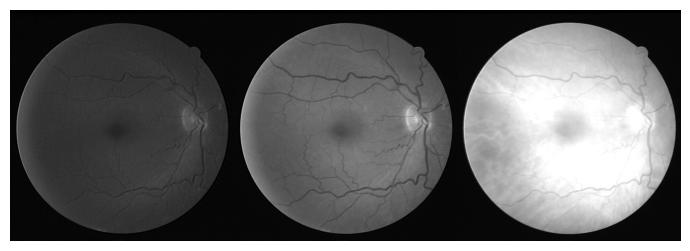

In [15]:
test_img = cv2.imread('DRIVE/Training/images/22_training.tif')
test_mask = np.array(imageio.mimread('DRIVE/Training/mask/22_training_mask.gif')).reshape(584, 565)

plot_images([test_img[:, :, 0], test_img[:, :, 1], test_img[:, :, 2]])

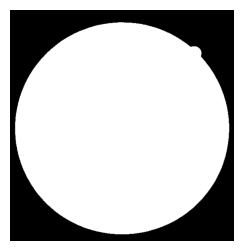

In [16]:
plot_images([test_mask])

You must select one of the red, green, or blue channels from the color image `(Explain your reasoning for the selection)`.

`Your response (2 pts):` green (2nd channel - test_img[:, :, 1]).
because the vessels of eye in retinal image has more contrast and are more distinguishable as used in the article, too.

همان طور که میبینیم رگ های چشم در کانال سبز بیشتر معلوم هستند و کنتراست بیشتری را در کانال سبز میبینیم و مقاله هم از این کانال استفاده کرده است.

## Pre-Process (10 pts)

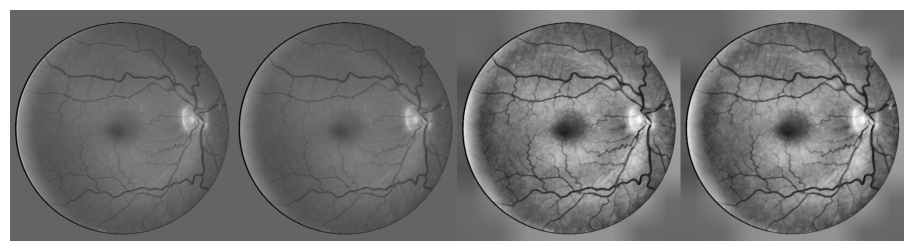

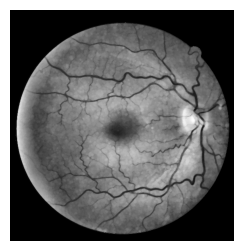

In [17]:
def PreProcess (image: np.ndarray, mask: np.ndarray,plot_image: bool) :
  """
      Args:
          - image (np.ndarray): A 2D  array, shape (height, width).
          - mask (np.ndarray): A binary mask array, shape (height, width).

      Returns:
          - Processed Image (np.ndarray): A 2D array of the same shape as image.

      Steps:
          - Mask Adjustment:
          - Morphological Opening
          - Contrast Enhancement
          - Smoothing


  """
  #################################################################################
  #                         YOUR CODE GOES HERE                                   #

  #first convert mask to binary mask
#   index = None
#   mask[index] = None
  index = (mask != 0)
  mask[index] = 1

  #replace zero masks with mean of the masked image
#   masked_image = None
#   mean = None
#   index = None
#   image[index] = None
  masked_image = np.multiply(image, mask)
  mean = np.mean(masked_image[masked_image != 0])
  index = (mask == 0)
  image[index] = mean

  SE = disk(2) # The line SE = disk(2) creates a structuring element in the shape of a disk (a circular shape) with a radius of 2 pixels.
  # now perform steps mentioned in document : you can refer to :
  # https://docs.opencv.org/3.4/d9/d61/tutorial_py_morphological_ops.html
  # https://docs.opencv.org/4.x/d6/db6/classcv_1_1CLAHE.html
  # https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#ga564869aa33e58769b4469101aac458f9


#   opening = None
#   clahe = None
#   clh = None
#   median = None
  opening = cv2.morphologyEx(image, cv2.MORPH_OPEN, SE)
  clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8,8))
  clh = clahe.apply(opening.astype(np.uint8))
#   median = cv2.medianBlur(clh, 5)
  median = cv2.medianBlur(clh, 3)

  #################################################################################
  if plot_image:
    plot_images([image,opening,clh,median])
  return np.multiply(median, mask)

test_img_preprocessed = PreProcess(test_img[:, :, 1], test_mask, plot_image=True)
plot_images([test_img_preprocessed])


## Feature Extraction (70 pts)

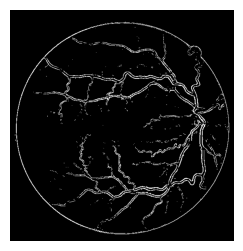

In [18]:
def Roberts_Edge_Detection(image):
    """
    Args:
        image (np.ndarray): A 2D grayscale image array of shape (height, width)


    Returns:
        np.ndarray: A binary image of the same shape as the input image.
    """
    #################################################################################
    #                         YOUR CODE GOES HERE                                   #

    # Roberts Edge Detection: The Roberts operator measures a 2-D spatial gradient on an image in a straightforward, quick-to-compute manner.
    image = image.astype('float64')/255.0
    # roberts_cross_v = None
    # roberts_cross_h = None
    roberts_cross_v = np.array([[1, 0], [0, -1]])
    roberts_cross_h = np.array([[0, 1], [-1, 0]])

    # vertical = None
    # horizontal = None
    # edged_img_sqrt = None
    # edged_img = None
    # _, edged_img_thresh = None
    vertical = ndi.convolve(image, roberts_cross_v)
    horizontal = ndi.convolve(image, roberts_cross_h)
    edged_img_sqrt = np.sqrt(np.square(horizontal) + np.square(vertical))

    # edged_img = edged_img_sqrt / np.max(edged_img_sqrt) * 255
    edged_img = (edged_img_sqrt - np.min(edged_img_sqrt)) / (np.max(edged_img_sqrt) - np.min(edged_img_sqrt))

    # _, edged_img_thresh = cv2.threshold(edged_img, 0.075, 1, cv2.THRESH_BINARY)
    _, edged_img_thresh = cv2.threshold(edged_img, 0.1, 1, cv2.THRESH_BINARY)

    edged_img = edged_img_thresh
    #################################################################################
    return edged_img
test_edged_img=Roberts_Edge_Detection(test_img_preprocessed)
plot_images([test_edged_img])

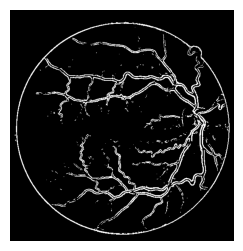

In [19]:
def Prewitt_Edge_Detection(image):
    """
    Args:
        image (np.ndarray): A 2D grayscale image array of shape (height, width)


    Returns:
        np.ndarray: A binary image of the same shape as the input image.
    """
    #################################################################################
    #                         YOUR CODE GOES HERE                                   #

    #Prewitt mask is a first-order derivative mask. In the graph representation of Prewitt-mask’s result, the edge is represented by the local maxima or local minima.
    # kernelx = None
    # kernely = None
    # image = None
    # img_prewittx = None
    # img_prewitty = None
    # edged_img_sqrt = None
    # edged_img = None
    # _, edged_img = None

    # kernelx = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
    # kernely = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
    kernelx = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    kernely = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])

    image = image.astype('float64') / 255.0
    img_prewittx = ndi.convolve(image, kernelx)
    img_prewitty = ndi.convolve(image, kernely)
    edged_img_sqrt = np.sqrt(np.square(img_prewittx) + np.square(img_prewitty))
    edged_img = (edged_img_sqrt - np.min(edged_img_sqrt)) / (np.max(edged_img_sqrt) - np.min(edged_img_sqrt))

    # _, edged_img = cv2.threshold(edged_img, 0.1, 1, cv2.THRESH_BINARY)
    _, edged_img = cv2.threshold(edged_img, 0.125, 1, cv2.THRESH_BINARY)
    #################################################################################
    return edged_img
test_edged_img=Prewitt_Edge_Detection(test_img_preprocessed)
plot_images([test_edged_img])

In [ ]:
# def LOG_Edge_Detection(image):
#     """
#     Args:
#         image (np.ndarray): A 2D grayscale image array of shape (height, width)


#     Returns:
#         np.ndarray: A binary image of the same shape as the input image.
#     """
#     #################################################################################
#     #                         YOUR CODE GOES HERE                                   #
#     blur = cv2.GaussianBlur(image, (3, 3), 0)

#     LoG = cv2.Laplacian(blur, cv2.CV_64F)

#     kernel = np.ones((3, 3), np.uint8)  # Structuring element for dilation
#     LoG = cv2.dilate(LoG, kernel, iterations=1)  # Dilation for minLoG

#     zeroCross = np.zeros_like(LoG)
#     # zeroCross = image.copy()

#     minLoG = (LoG < -6).astype(np.uint8)  # Create a mask for values smaller than -6
#     maxLoG = (LoG > 6).astype(np.uint8)   # Create a mask for values larger than 6

#     # kernel = np.ones((3, 3), np.uint8)  # Structuring element for dilation
#     # minLoG_dilated = cv2.dilate(minLoG, kernel, iterations=1)  # Dilation for minLoG
#     # maxLoG_dilated = cv2.dilate(maxLoG, kernel, iterations=1)  # Dilation for maxLoG

#     # zeroCross[minLoG_dilated > 0] = 255
#     # zeroCross[maxLoG_dilated > 0] = 255
#     zeroCross[minLoG > 0] = 255
#     zeroCross[maxLoG > 0] = 255
#     # zeroCross[LoG < 0] = 0
#     #################################################################################
#     return zeroCross
# test_edged_img=LOG_Edge_Detection(test_img_preprocessed)
# plot_images([test_edged_img])

In [ ]:
# def LOG_Edge_Detection(image):
#     """
#     Args:
#         image (np.ndarray): A 2D grayscale image array of shape (height, width)


#     Returns:
#         np.ndarray: A binary image of the same shape as the input image.
#     """
#     #################################################################################
#     #                         YOUR CODE GOES HERE                                   #

#     blur = cv2.GaussianBlur(image, (3, 3), 0)

#     LoG = cv2.Laplacian(blur, cv2.CV_64F)
#     kernel = np.ones((3, 3), np.uint8)
#     LoG = cv2.dilate(LoG, kernel, iterations=1)

#     zeroCross = np.zeros_like(LoG, dtype=np.uint8)

#     for i in range(1, LoG.shape[0] - 1):
#         for j in range(1, LoG.shape[1] - 1):
#             # Get the 3x3 neighborhood around the pixel
#             patch = LoG[i-1:i+2, j-1:j+2]
#             center_pixel = LoG[i, j]

#             # If the center pixel is positive, check for negative neighbors
#             if center_pixel > 0 and np.any(patch < 0):
#                 zeroCross[i, j] = 255  # Mark as a zero-crossing

#             # If the center pixel is negative, check for positive neighbors
#             elif center_pixel < 0 and np.any(patch > 0):
#                 zeroCross[i, j] = 255  # Mark as a zero-crossing

#     minLoG = (LoG < -6).astype(np.uint8)
#     maxLoG = (LoG > 6).astype(np.uint8)

#     # # Apply morphological dilation to enhance the regions
#     # kernel = np.ones((3, 3), np.uint8)
#     # minLoG_dilated = cv2.dilate(minLoG, kernel, iterations=1)
#     # maxLoG_dilated = cv2.dilate(maxLoG, kernel, iterations=1)
#     # # minLoG_dilated = cv2.morphologyEx(minLoG, cv2.MORPH_OPEN, kernel)
#     # # maxLoG_dilated = cv2.morphologyEx(maxLoG, cv2.MORPH_OPEN, kernel)
#     # # Combine zero-crossing result with minLoG and maxLoG
#     # zeroCross[minLoG_dilated > 0] = 255
#     # zeroCross[maxLoG_dilated > 0] = 255

#     zeroCross[minLoG > 0] = 255
#     zeroCross[maxLoG > 0] = 255


#     # # ###
#     # blur = cv2.GaussianBlur(image, (5, 5), 0)

#     # LoG = cv2.Laplacian(blur, cv2.CV_64F)

#     # LoG = (LoG - np.min(LoG)) / (np.max(LoG) - np.min(LoG))

#     # kernel = np.ones((3, 3), np.uint8)

#     # minLoG = cv2.dilate(LoG, kernel, iterations=1)
#     # maxLoG = cv2.dilate(-LoG, kernel, iterations=1)

#     # zeroCross = np.zeros(LoG.shape, dtype=np.uint8)

#     # rows, cols = LoG.shape
#     # for i in range(1, rows - 1):
#     #     for j in range(1, cols - 1):
#     #         neighborhood = LoG[i-1:i+2, j-1:j+2]
#     #         if np.min(neighborhood) < 0 and np.max(neighborhood) > 0:
#     #             if minLoG[i, j] < -6 or maxLoG[i, j] > 6:
#     #                 zeroCross[i, j] = 255
#     #################################################################################
#     return zeroCross
# test_edged_img=LOG_Edge_Detection(test_img_preprocessed)
# plot_images([test_edged_img])

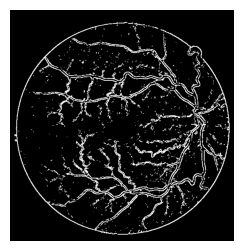

In [21]:
def LOG_Edge_Detection(image):
    """
    Args:
        image (np.ndarray): A 2D grayscale image array of shape (height, width)


    Returns:
        np.ndarray: A binary image of the same shape as the input image.
    """
    #################################################################################
    #                         YOUR CODE GOES HERE                                   #
    blur = cv2.GaussianBlur(image, (3, 3), .8)
    LoG = cv2.Laplacian(blur, cv2.CV_64F)
    kernel = np.ones((3, 3), np.uint8)
    minLoG = cv2.dilate((LoG < -6).astype(np.uint8) * 255, kernel)
    maxLoG = cv2.dilate((LoG > 6).astype(np.uint8) * 255, kernel)
    zeroCross = np.logical_and(minLoG, maxLoG)
    #################################################################################
    return zeroCross
test_edged_img=LOG_Edge_Detection(test_img_preprocessed)
plot_images([test_edged_img])

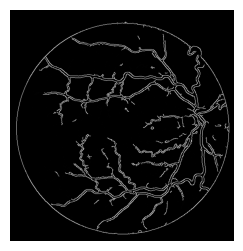

In [22]:
def Edge_Algorithm_features(image):
    """
      Extract edge features from a grayscale image using Roberts, Prewitt and LOG edge detection algorithms.

      Args:
          image (np.ndarray): A 2D grayscale image array of shape (height, width)

      Returns:
          np.ndarray: A binary image of the same shape as the input image.
    """
    #################################################################################
    #                         YOUR CODE GOES HERE                                   #
    #Roberts, Prewitt, Sobel, Canny, Log
    # R = None
    # P = None
    # S = None
    # _, S = None
    # C = None
    # L = None
    R = Roberts_Edge_Detection(image)
    P = Prewitt_Edge_Detection(image)
    S = cv2.Sobel(image, cv2.CV_64F, 1, 1, ksize=5)
    _, S = cv2.threshold(S, 0.1, 1, cv2.THRESH_BINARY)
    C = cv2.Canny(image.astype(np.uint8), 100, 200)
    L = LOG_Edge_Detection(image)
    #################################################################################
    return R + P + S + C + L
test_edged_img=Edge_Algorithm_features(test_img_preprocessed)
plot_images([test_edged_img])

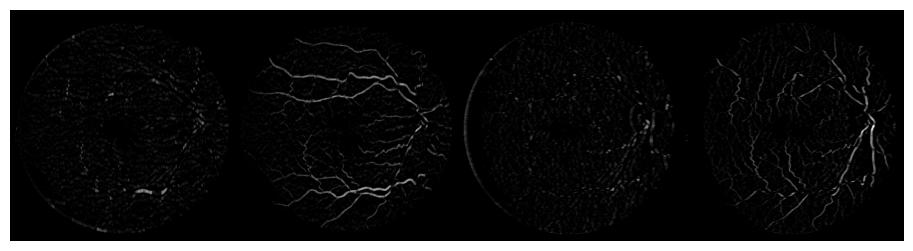

In [23]:
def Morphological_features(image):
    """
      Extract morphological features from a grayscale image using
      top-hat and black-hat morphological transformations.

      Args:
          image (np.ndarray): A 2D grayscale image array of shape (height, width).

      Returns:
          tuple: A tuple containing four elements:
              - tophat_img (np.ndarray): The top-hat transformed image, highlighting
                bright features on a dark background.
              - bothat_img (np.ndarray): The black-hat transformed image, emphasizing
                dark features on a bright background.
              - tophat_img2 (np.ndarray): The second top-hat transformed image with
                a different structuring element orientation.
              - bothat_img2 (np.ndarray): The second black-hat transformed image with
                a different structuring element orientation.

    """
    #################################################################################
    #                         YOUR CODE GOES HERE                                   #
    # kernel = None
    # tophat_img = None
    # bothat_img = None
    # kernel_size = (9, 9)
    kernel_size = (1, 11)
    # kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, kernel_size)
    # kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    tophat_img = cv2.morphologyEx(image, cv2.MORPH_TOPHAT, kernel)
    bothat_img = cv2.morphologyEx(image, cv2.MORPH_BLACKHAT, kernel)

    ######### new features added #################################
    # kernel = None
    # tophat_img2 = None
    # bothat_img2 = None
    kernel_size = (11, 1)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    tophat_img2 = cv2.morphologyEx(image, cv2.MORPH_TOPHAT, kernel)
    bothat_img2 = cv2.morphologyEx(image, cv2.MORPH_BLACKHAT, kernel)
    #################################################################################
    return tophat_img, bothat_img, tophat_img2, bothat_img2
test_morph_image=Morphological_features(test_img_preprocessed)
plot_images(test_morph_image)


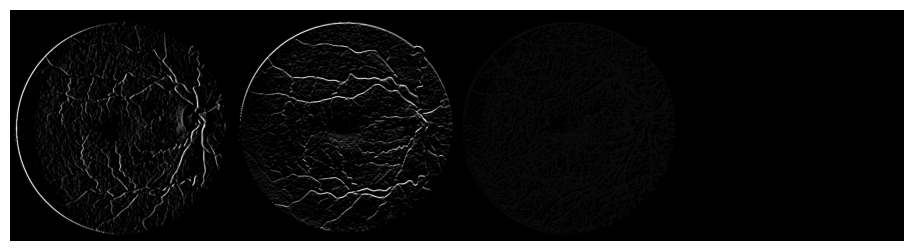

In [24]:
def Gradient_Based_features (image) :
  """
      Calculate gradient-based features from a grayscale image using
      convolution with Sobel-like kernels.

      Args:
          image (np.ndarray): A 2D grayscale image array of shape (height, width).


      Returns:
          tuple: A tuple containing four elements:
              - Gx (np.ndarray): The gradient of the image in the x-direction.
              - Gy (np.ndarray): The gradient of the image in the y-direction.
              - M (np.ndarray): The magnitude of the gradient.
              - Theta (np.ndarray): The angle of the gradient direction.
  """
  #################################################################################
  #                         YOUR CODE GOES HERE                                   #
#   dx_kernel = None
#   dy_kernel = None

#   Gx = None
#   Gy = None
#   M = None
#   Theta = None

  dx_kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
  dy_kernel = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

  Gx = cv2.filter2D(image, -1, dx_kernel)
  Gy = cv2.filter2D(image, -1, dy_kernel)
#   Gx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # Gradient in x direction
#   Gy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)  # Gradient in y direction
  M = np.sqrt(Gx**2 + Gy**2)
  Theta = np.arctan2(Gy, Gx)

  #################################################################################
  return Gx, Gy, M, Theta
test_gradient_image=Gradient_Based_features(test_img_preprocessed)
plot_images(test_gradient_image)


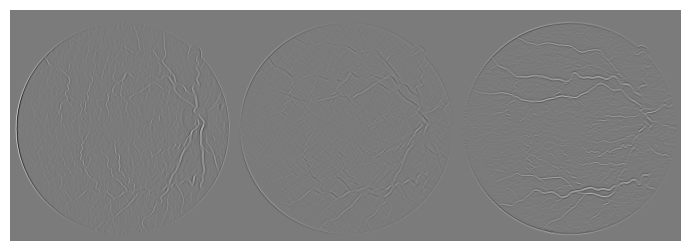

In [25]:
def Hessian_features(image) :
  """
    Calculate Hessian matrix components for a given grayscale image
    to capture second-order derivative information for edge detection.

    Args:
        image (np.ndarray): A 2D grayscale image array of shape (height, width).

    Returns:
        tuple: A tuple containing three elements:
            - Gxx (np.ndarray): The second derivative of the image with respect
              to the x-direction.
            - Gxy (np.ndarray): The mixed second derivative of the image with respect
              to both x and y directions.
            - Gyy (np.ndarray): The second derivative of the image with respect
              to the y-direction.
  """
  #################################################################################
  #                         YOUR CODE GOES HERE                                   #
#   Ix = None  # X edges
#   Iy = None  # Y edges

#   Gxx = None
#   Gxy = None
#   Gyy = None
  # First derivatives (gradients)
  Ix = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # Gradient in x-direction
  Iy = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)  # Gradient in y-direction

  # Second-order derivatives (Hessian components)
  Gxx = cv2.Sobel(Ix, cv2.CV_64F, 1, 0, ksize=3)  # Second derivative in x
  Gxy = cv2.Sobel(Ix, cv2.CV_64F, 0, 1, ksize=3)  # Mixed second derivative
  Gyy = cv2.Sobel(Iy, cv2.CV_64F, 0, 1, ksize=3)  # Second derivative in y

  #################################################################################
  return Gxx, Gxy, Gyy

test_hessian_image=Hessian_features(test_img_preprocessed)
plot_images(test_hessian_image)

In [ ]:
def Statistical_features(image, index):
    """
    Compute statistical features from a given grayscale image.

    Args:
        image (np.ndarray): A 2D grayscale image array of shape (height, width).
        index (tuple(np.ndarray,np.ndarray)): A tuple of two vector which contains x and y coordinates of non-zero pixels
    Returns:
        np.ndarray: A 3D array of shape (height, width, 8) containing the following
                    statistical features for each pixel:
                    - Mean
                    - Minimum
                    - Maximum
                    - Skewness
                    - Kurtosis
                    - Standard Deviation
                    - Mean Absolute Deviation
                    - Root Sum of Squared Levels
    """

    #################################################################################
    #                         YOUR CODE GOES HERE                                   #


    # Mean, Minimum, Maximum, Skewness, Kurtosis, Standard deviation,
    # Mean absolute deviation, Root sum of squared level, size = 21
    k = 10
    img = cv2.copyMakeBorder(image, k, k, k, k, cv2.BORDER_CONSTANT, None, image.mean())
    output = np.zeros((image.shape[0], image.shape[1], 8))
    X, Y = index

    for idx in tqdm(range(len(index[0]))):

            i = X[idx] + k
            j = Y[idx] + k
            # output[i-2*k, j-2*k, 0] = None #mean
            # output[i-2*k, j-2*k, 1] = None #min
            # output[i-2*k, j-2*k, 2] = None #max
            # output[i-2*k, j-2*k, 3] = None #skew
            # output[i-2*k, j-2*k, 4] = None #kurtosis
            # output[i-2*k, j-2*k, 5] = None #std
            # output[i-2*k, j-2*k, 6] = None #mean absolute deviation
            # output[i-2*k, j-2*k, 7] = None #root sum of squared level

            window = img[i-k:i+k+1, j-k:j+k+1].flatten() # # Local window around the pixel
            output[i-2*k, j-2*k, 0] = np.mean(window)
            output[i-2*k, j-2*k, 1] = np.min(window)
            output[i-2*k, j-2*k, 2] = np.max(window)
            output[i-2*k, j-2*k, 3] = skew(window)
            output[i-2*k, j-2*k, 4] = kurtosis(window)
            output[i-2*k, j-2*k, 5] = np.std(window)
            output[i-2*k, j-2*k, 6] = np.mean(np.abs(window - np.mean(window)))
            output[i-2*k, j-2*k, 7] = np.sqrt(np.sum(window**2))

    #################################################################################
    return [stat for stat in output[:, :]]
index = np.where(test_mask != 0)
test_statistic_features = Statistical_features(test_img_preprocessed,index)
mean, min, max, Skewness, Kurtosis, std, mad, sqrt = np.transpose(test_statistic_features, (2, 0, 1))[:]
test_statistic_features = np.stack((mean[index],  min[index],  max[index],  Skewness[index],  Kurtosis[index],  std[index],  mad[index],  sqrt[index]), axis=1)
data = pd.DataFrame()
df = pd.DataFrame(test_statistic_features)
df

100%|██████████| 227686/227686 [06:47<00:00, 559.26it/s]


,0,1,2,3,4,5,6,7
0,79.455782,0.0,139.0,-2.301267,4.642578,22.935945,14.583121,247.729691
1,79.544218,0.0,139.0,-2.325725,4.805459,22.786368,14.473568,247.440902
2,79.614512,0.0,139.0,-2.335677,4.897703,22.692985,14.440208,245.340580
3,79.666667,0.0,139.0,-2.331457,4.912113,22.666367,14.467120,244.415630
4,79.657596,0.0,139.0,-2.319268,4.885009,22.664631,14.502188,243.563133
...,...,...,...,...,...,...,...,...
227681,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
227682,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
227683,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
227684,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000




1. **Setup Paths**: Defines paths for images, masks, and labels from the DRIVE dataset.
   
2. **Load File Lists**: Retrieves and sorts the filenames for images, masks, and labels from the specified directories.

3. **Initialize DataFrame**: Creates an empty DataFrame to store the extracted features from each processed image.

4. **Image Processing Loop**: Iterates over the first 20 images:
   - Reads each image and its corresponding mask and label.
   - Reshapes the mask and label arrays to standard dimensions.
   - Converts label values from 255 to 1 for binary representation.
   - Applies preprocessing to the image using the `PreProcess` function.

5. **Feature Extraction**: Extracts various features from the preprocessed image:
   - Edge features using the `Edge_Algorithm_features` function.
   - Morphological features using the `Morphological_features` function.
   - Statistical features (mean, min, max, skewness, kurtosis, standard deviation, mean absolute deviation, and root sum of squares) using the `Statistical_features` function.
   - Gradient-based features (Gx, Gy, magnitude, and angle) using the `Gradient_Based_features` function.
   - Hessian features using the `Hessian_features` function.

6. **Feature Compilation**: Stacks the extracted features along with the corresponding label and creates a DataFrame from the features.

7. **Data Storage**: Concatenates the newly created DataFrame with the main DataFrame to accumulate all extracted features.

This step prepares the data for  model training.



In [26]:
# because using a tqdm in another tqdm isn't appropreiate we redefine without tqdm

def Statistical_features(image, index):
    """
    Compute statistical features from a given grayscale image.

    Args:
        image (np.ndarray): A 2D grayscale image array of shape (height, width).
        index (tuple(np.ndarray,np.ndarray)): A tuple of two vector which contains x and y coordinates of non-zero pixels
    Returns:
        np.ndarray: A 3D array of shape (height, width, 8) containing the following
                    statistical features for each pixel:
                    - Mean
                    - Minimum
                    - Maximum
                    - Skewness
                    - Kurtosis
                    - Standard Deviation
                    - Mean Absolute Deviation
                    - Root Sum of Squared Levels
    """

    #################################################################################
    #                         YOUR CODE GOES HERE                                   #


    # Mean, Minimum, Maximum, Skewness, Kurtosis, Standard deviation,
    # Mean absolute deviation, Root sum of squared level, size = 21
    k = 10
    img = cv2.copyMakeBorder(image, k, k, k, k, cv2.BORDER_CONSTANT, None, image.mean())
    output = np.zeros((image.shape[0], image.shape[1], 8))
    X, Y = index

    for idx in range(len(index[0])):

            i = X[idx] + k
            j = Y[idx] + k
            window = img[i-k:i+k+1, j-k:j+k+1].flatten() # # Local window around the pixel
            output[i-2*k, j-2*k, 0] = np.mean(window)
            output[i-2*k, j-2*k, 1] = np.min(window)
            output[i-2*k, j-2*k, 2] = np.max(window)
            output[i-2*k, j-2*k, 3] = skew(window)
            output[i-2*k, j-2*k, 4] = kurtosis(window)
            output[i-2*k, j-2*k, 5] = np.std(window)
            output[i-2*k, j-2*k, 6] = np.mean(np.abs(window - np.mean(window)))
            output[i-2*k, j-2*k, 7] = np.sqrt(np.sum(window**2))

    #################################################################################
    return [stat for stat in output[:, :]]

In [27]:
train_image_path = 'DRIVE/Training/images/'
train_mask_path = 'DRIVE/Training/mask/'
train_label_path = 'DRIVE/Training/1st_manual/'

test_image_path = 'DRIVE/Test/images/'
test_mask_path = 'DRIVE/Test/mask/'
test_label_path = 'DRIVE/Test/1st_manual/'
def extract_features(image_path, mask_path, label_path):

        images = [f for f in listdir(image_path) if isfile(join(image_path, f))]
        images.sort()
        masks = [f for f in listdir(mask_path) if isfile(join(mask_path, f))]
        masks.sort()
        labels = [f for f in listdir(label_path) if isfile(join(label_path, f))]
        labels.sort()
        data = pd.DataFrame()
        for i in tqdm(range(len(images)), position=0, leave=True):
            image = cv2.imread(join(image_path, images[i]))
            mask = np.array(imageio.mimread(join(mask_path, masks[i]))).reshape(584, 565)
            label = np.array(imageio.mimread(join(label_path, labels[i]))).reshape(584, 565)
            label[np.where(label == 255)] = 1
            index = np.where(mask != 0)
            image = PreProcess(image[:, :, 1], mask,False)

            ################# feature extraction######################################

            edges = Edge_Algorithm_features(image)
            (tophat, bothat, tophat2, bothat2) = Morphological_features(image)
            mean, min, max, Skewness, Kurtosis, std, mad, sqrt = np.transpose(Statistical_features(image, index), (2, 0, 1))[:]
            (Gx, Gy, M, Theta) = Gradient_Based_features(image)
            (Gxx, Gxy, Gyy) = Hessian_features(image)
            features = np.stack((edges[index], tophat[index], bothat[index], Gx[index], Gy[index], tophat2[index], bothat2[index],
                                mean[index],  min[index],  max[index],  Skewness[index],  Kurtosis[index],  std[index],  mad[index],  sqrt[index],
                                M[index], Theta[index], Gxx[index], Gxy[index], Gyy[index], label[index]), axis=1)

            df = pd.DataFrame(features)
            data = pd.concat([data, df])

        return data



df_train = extract_features(train_image_path, train_mask_path, train_label_path)
df_test = extract_features(test_image_path, test_mask_path, test_label_path)

100%|██████████| 20/20 [2:08:21<00:00, 385.08s/it]


In [29]:
df_train.to_csv("train.csv")
df_test.to_csv("test.csv")


# df_train=pd.DataFrame.from_csv("train.csv")
# df_test=pd.DataFrame.from_csv("test.csv")
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_train

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,16,17,18,19,20
0,0,2.0,0.0,0.0,16.0,255.0,0.0,0.0,121.668934,50.0,...,2.042596,21.807947,15.710254,174.774140,1.000000,1.507812,102.0,-474.0,1062.0,0.0
1,1,1.0,0.0,0.0,18.0,206.0,0.0,0.0,121.664399,0.0,...,3.350124,22.122537,15.748531,177.611937,2.828125,1.483398,190.0,-94.0,630.0,0.0
2,2,2.0,0.0,0.0,48.0,228.0,0.0,0.0,121.621315,0.0,...,4.473144,22.452558,15.822605,179.963885,4.000000,1.363281,34.0,102.0,402.0,0.0
3,3,2.0,0.0,0.0,30.0,254.0,3.0,0.0,121.573696,0.0,...,5.440780,22.876473,15.957405,184.287818,11.664062,1.453125,-159.0,73.0,241.0,0.0
4,4,2.0,0.0,0.0,0.0,255.0,3.0,0.0,121.546485,0.0,...,6.199041,23.416823,16.139088,188.880915,1.000000,1.570312,-99.0,23.0,153.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4541001,226969,2.0,0.0,0.0,3.0,0.0,25.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,-28.0,-2.0,-116.0,0.0
4541002,226970,3.0,0.0,0.0,0.0,0.0,25.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.0,1.0,-139.0,0.0
4541003,226971,2.0,0.0,0.0,0.0,0.0,25.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-86.0,-32.0,-94.0,0.0
4541004,226972,258.0,0.0,0.0,0.0,0.0,25.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-71.0,-105.0,109.0,0.0


In [30]:
df_test

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,16,17,18,19,20
0,0,258.0,22.0,0.0,163.0,255.0,35.0,0.0,104.582766,84.0,...,-0.206310,9.273035,7.091006,223.872732,14.210938,1.001953,-839.0,-215.0,-659.0,0.0
1,1,257.0,0.0,0.0,0.0,255.0,8.0,7.0,104.378685,84.0,...,-0.353461,9.390225,7.345345,228.571652,1.000000,1.570312,-383.0,-93.0,-1391.0,0.0
2,2,258.0,0.0,0.0,18.0,255.0,8.0,7.0,104.383220,84.0,...,-0.443721,9.502146,7.539441,232.609114,8.304688,1.500000,257.0,21.0,-1479.0,0.0
3,3,258.0,0.0,0.0,18.0,255.0,14.0,1.0,104.458050,84.0,...,-0.495333,9.571485,7.680421,235.452755,8.304688,1.500000,-60.0,38.0,-1492.0,0.0
4,4,3.0,0.0,0.0,0.0,255.0,14.0,1.0,104.625850,84.0,...,-0.545283,9.652143,7.844787,235.512208,1.000000,1.570312,-53.0,15.0,-1537.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4538138,227518,2.0,0.0,0.0,15.0,0.0,34.0,6.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,15.000000,0.000000,-161.0,-39.0,739.0,0.0
4538139,227519,2.0,0.0,0.0,18.0,0.0,39.0,1.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,8.250000,0.000000,-29.0,-47.0,611.0,0.0
4538140,227520,2.0,0.0,0.0,3.0,0.0,40.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,-49.0,-49.0,603.0,0.0
4538141,227521,2.0,0.0,0.0,0.0,0.0,40.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,63.0,-197.0,731.0,0.0


In [31]:
# Define file paths in your Google Drive
train_file_path = '/content/drive/MyDrive/IABI_HW1/df_train.csv'
test_file_path = '/content/drive/MyDrive/IABI_HW1/df_test.csv'

# Save DataFrames as CSV
df_train.to_csv(train_file_path)
df_test.to_csv(test_file_path)

In [ ]:
# import pandas as pd

# # Define file paths in your Google Drive
# train_file_path = '/content/drive/MyDrive/df_train.csv'
# test_file_path = '/content/drive/MyDrive/df_test.csv'

# # Load the CSV files into DataFrames
# df_train = pd.read_csv(train_file_path)
# df_test = pd.read_csv(test_file_path)

## Training Phase (18 pts)

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

- **Note**: Due to the significant differences in the scale of the extracted features, the values should normalize before training the neural network.


In [33]:
sc = StandardScaler()

shuffled = df_train.sample(frac=1)
X_train = sc.fit_transform(shuffled.iloc[:, 1:21]) # first column is index and last column is label
Y_train = shuffled.iloc[:, -1].astype(int).to_numpy()


X_test = sc.fit_transform(df_test.iloc[:, 1:21]) # I think we should use fit here and fit_transform but I did not change source code!!!
Y_test = df_test.iloc[:, -1].astype(int).to_numpy()

- **Note**: Since the number of foreground pixels is much smaller than the background pixels, a weighted binary cross-entropy loss is used, with a higher weight assigned to errors in detecting blood vessels.(9pt)

In [34]:
class MyDataset(Dataset):

  def __init__(self,X, Y):

    self.x_train=torch.tensor(X,dtype=torch.float32)
    self.y_train=torch.tensor(Y,dtype=torch.float32)

  def __len__(self):
    return len(self.y_train)

  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]


class Classifier(nn.Module):
   def __init__(self):
      super(Classifier, self).__init__()
      self.fc1 = nn.Linear(20, 32)
      self.fc2 = nn.Linear(32, 32)
      self.fc4 = nn.Linear(32,16)
      self.fc3 = nn.Linear(16,1)
   def forward(self, x):
      x = torch.tanh(self.fc1(x))
      x = torch.tanh(self.fc2(x))
      x = torch.tanh(self.fc4(x))
      return torch.sigmoid(self.fc3(x))

class weighted_binary_cross_entropy(nn.Module):
    def __init__(self):
      super(weighted_binary_cross_entropy, self).__init__()

    def forward(self, output, target, weights=None):
        output = torch.clamp(output,min=1e-8,max=1-1e-8)

        if weights is not None:
            assert len(weights) == 2
            #################################################################################
            #                         YOUR CODE GOES HERE                                   #
            #implement weighted cross entropy loss
            # loss = None
            loss = weights[1] * (target * torch.log(output)) + \
                   weights[0] * ((1 - target) * torch.log(1 - output))
        else:
            loss = target * torch.log(output) + (1 - target) * torch.log(1 - output)

        return torch.neg(torch.mean(loss))

In [35]:
#####################################
###### DO NOT CHANGE THIS CELL ######
#####################################

N_EPOCHS = 20
BATCH_SIZE = 128
LR = 1e-2
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader = DataLoader(MyDataset(X_train, Y_train), batch_size=BATCH_SIZE, shuffle=False)
model = Classifier().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
criterion = weighted_binary_cross_entropy()

- After generating the probability of each pixel being part of a blood vessel. A fixed threshold of `0.4` should choose to binarize these values.

In [36]:
# training loop
def train_model(model, train_dataloader, n_epochs, optimizer, criterion, device):
    model.train()
    train_losses = []
    train_accuracies = []
    for epoch in tqdm(range(n_epochs)):
    #################################################################################
    #                         YOUR CODE GOES HERE                                   #

        epoch_loss = 0
        correct=0
        total=0
        for data, target in train_dataloader:

            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            output = output.reshape(target.shape)
            loss = criterion(output, target, [1, 1.2])  # Weighting vessel pixels higher
            loss.backward()
            optimizer.step()

            predicted = (output >= 0.4)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
            epoch_loss += loss.item()

        accu = 100.0 * correct/total
        train_loss = epoch_loss / len(train_loader)
        train_accuracies.append(accu)
        train_losses.append(train_loss)

    #################################################################################
        print('Epoch: {}  Train Loss: {:.4f}  Accuracy: {:.3f}'.format(epoch+1, train_loss, accu))

    return model, train_losses, train_accuracies


In [37]:
trained_model, train_losses, train_accuracies = train_model(model, train_loader, N_EPOCHS, optimizer, criterion, DEVICE)

  5%|▌         | 1/20 [02:54<55:19, 174.73s/it]

Epoch: 1  Train Loss: 0.2190  Accuracy: 92.686


 10%|█         | 2/20 [05:00<43:43, 145.73s/it]

Epoch: 2  Train Loss: 0.2018  Accuracy: 93.326


 15%|█▌        | 3/20 [07:07<38:56, 137.42s/it]

Epoch: 3  Train Loss: 0.1961  Accuracy: 93.489


 20%|██        | 4/20 [09:06<34:40, 130.06s/it]

Epoch: 4  Train Loss: 0.1943  Accuracy: 93.532


 25%|██▌       | 5/20 [11:09<31:50, 127.38s/it]

Epoch: 5  Train Loss: 0.1932  Accuracy: 93.552


 30%|███       | 6/20 [13:10<29:12, 125.19s/it]

Epoch: 6  Train Loss: 0.1925  Accuracy: 93.563


 35%|███▌      | 7/20 [15:07<26:34, 122.67s/it]

Epoch: 7  Train Loss: 0.1920  Accuracy: 93.574


 40%|████      | 8/20 [17:11<24:36, 123.05s/it]

Epoch: 8  Train Loss: 0.1915  Accuracy: 93.578


 45%|████▌     | 9/20 [19:12<22:26, 122.38s/it]

Epoch: 9  Train Loss: 0.1912  Accuracy: 93.584


 50%|█████     | 10/20 [21:08<20:04, 120.48s/it]

Epoch: 10  Train Loss: 0.1908  Accuracy: 93.588


 55%|█████▌    | 11/20 [23:08<18:03, 120.38s/it]

Epoch: 11  Train Loss: 0.1905  Accuracy: 93.595


 60%|██████    | 12/20 [25:09<16:03, 120.49s/it]

Epoch: 12  Train Loss: 0.1902  Accuracy: 93.601


 65%|██████▌   | 13/20 [27:06<13:55, 119.41s/it]

Epoch: 13  Train Loss: 0.1899  Accuracy: 93.609


 70%|███████   | 14/20 [29:04<11:54, 119.13s/it]

Epoch: 14  Train Loss: 0.1896  Accuracy: 93.616


 75%|███████▌  | 15/20 [31:05<09:57, 119.57s/it]

Epoch: 15  Train Loss: 0.1893  Accuracy: 93.623


 80%|████████  | 16/20 [33:03<07:56, 119.09s/it]

Epoch: 16  Train Loss: 0.1891  Accuracy: 93.629


 85%|████████▌ | 17/20 [35:01<05:56, 118.71s/it]

Epoch: 17  Train Loss: 0.1889  Accuracy: 93.636


 90%|█████████ | 18/20 [37:01<03:58, 119.29s/it]

Epoch: 18  Train Loss: 0.1887  Accuracy: 93.641


 95%|█████████▌| 19/20 [39:03<02:00, 120.02s/it]

Epoch: 19  Train Loss: 0.1885  Accuracy: 93.645


100%|██████████| 20/20 [40:58<00:00, 122.93s/it]

Epoch: 20  Train Loss: 0.1884  Accuracy: 93.649


--------------
In order to `evaluate` the method, three metrics will be used: accuracy, specificity, and sensitivity, each of which is defined as follows:

First, we define the parameters TP, TN, FP, and FN, which will be used to calculate the mentioned metrics.

`TP`: The number of pixels that are part of the vessel, and the method also correctly identifies them as vessels.

`TN`: The number of pixels that belong to the background, and the method also correctly identifies them as background.

`FP`: The number of pixels that belong to the background, but the method incorrectly identifies them as vessels.

`FN`: The number of pixels that are part of the vessel, but the method incorrectly identifies them as background.

With these definitions in place, the three metrics are defined as follows:


$
\text{Sensitivity} = \frac{TP}{TP + FN}
$


$
\text{Specificity} = \frac{TN}{TN + FP}
$


$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$


In [38]:
def evaluation(image, label, mask) :

  TP = TN =  FP = FN = 0
  row, col = image.shape
  for i in range(row):
    for j in range(col):

     # if mask[i, j] != 0:
        p = image[i, j]
        l = label[i, j]
        if p != 0 and l != 0:
          TP +=1
        elif p != 0 and l == 0 :
          FP +=1
        elif p == 0 and l == 0 :
          TN +=1
        elif p == 0 and l != 0 :
          FN +=1

  Sn = TP/(TP + FN)
  Sp = TN/(TN + FP)
  Acc = (TP + TN)/(TP + TN + FP + FN)

  return Sn, Sp, Acc

-----
- `Note`: you must reach at least `70%` sensitivity, `90%` specificity, and `90%` accuracy. (3 pts)

I reached !!!

In [39]:
test_image_path = 'DRIVE/Test/images/'
test_mask_path = 'DRIVE/Test/mask/'
test_label_path = 'DRIVE/Test/1st_manual/'

images = [f for f in listdir(test_image_path) if isfile(join(test_image_path, f))]
images.sort()

masks = [f for f in listdir(test_mask_path) if isfile(join(test_mask_path, f))]
masks.sort()

labels = [f for f in listdir(test_label_path) if isfile(join(test_label_path, f))]
labels.sort()




sum = 0
cnt = 0
sn = sp = acc = 0

for i in tqdm(range(len(images))) :
  image = cv2.imread(join(test_image_path, images[i]))
  mask = np.array(imageio.mimread(join(test_mask_path, masks[i]))).reshape(584, 565)
  label = np.array(imageio.mimread(join(test_label_path, labels[i]))).reshape(584, 565)
  label[np.where(label == 255)] = 1
  index = np.where(mask != 0)
  cnt = index[0].shape[0]

  temp = np.zeros((584, 565))
  X = torch.from_numpy(X_test[sum:sum+cnt, :]).to(DEVICE)
  Y = Y_test[sum:sum+cnt]

  out = model(X.float()).reshape(Y.shape) >= 0.4

  x, y = index
  for idx in range(cnt,) :
    m = x[idx]
    n = y[idx]

    if out[idx] == 1:
      temp[m, n] = 255

  sum += cnt

  ########## for removing borders of mask ##############
  border = LOG_Edge_Detection(mask)
  kernel = np.ones((4, 4), np.uint8)
  border = cv2.dilate(border.astype('uint8'), kernel, iterations=1)
  idx = np.where(border != 0)
  temp[idx] = 0

  SN, SP, ACC = evaluation(temp, label, mask)

  sn += SN
  sp += SP
  acc += ACC


print(sn/len(images))
print(sp/len(images))
print(acc/len(images))

100%|██████████| 20/20 [01:34<00:00,  4.73s/it]

0.7320158431866186
0.9806006616047643
0.9586884773911988


- Show two sample images along with their ground truth and the model output at the end. (6 pts)

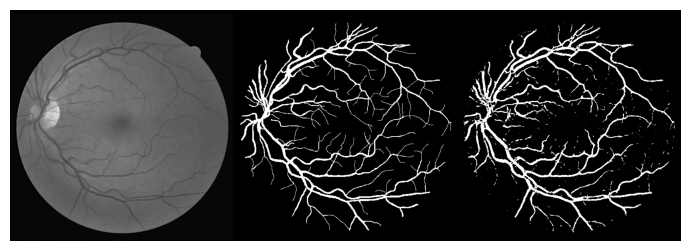

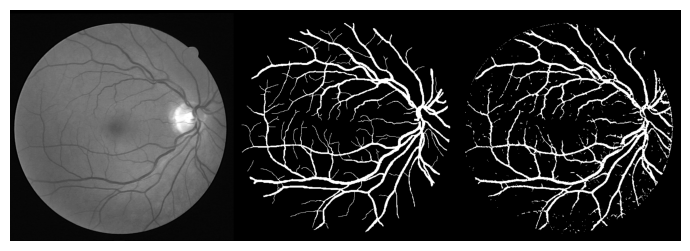

In [46]:
sum_pixels = 0

sample_idx = [0, 1]  # Index of two images to show
for idx in sample_idx:
    image = cv2.imread(join(test_image_path, images[idx]))
    mask = np.array(imageio.mimread(join(test_mask_path, masks[idx]))).reshape(584, 565)
    label = np.array(imageio.mimread(join(test_label_path, labels[idx]))).reshape(584, 565)
    label[np.where(label == 255)] = 1
    index = np.where(mask != 0)
    cnt = index[0].shape[0]  # Count of pixels in the mask

    temp = np.zeros((584, 565))

    # Extract the appropriate slice from X_test and Y_test based on sum_pixels
    X = torch.from_numpy(X_test[sum_pixels:sum_pixels + cnt, :]).to(DEVICE)
    Y = Y_test[sum_pixels:sum_pixels + cnt]

    out = model(X.float()).reshape(Y.shape) >= 0.4 # Run the model and threshold the output to binarize it

    # Map the output back to the pixel grid
    x, y = index
    for idx in range(cnt):
        m = x[idx]
        n = y[idx]
        if out[idx] == 1:
            temp[m, n] = 255

    sum_pixels += cnt

    label[np.where(label == 1)] = 255
    plot_images([image[:, :, 1], label, temp])  # Display original, ground truth, and output